## Курсовая работа
## Интерполяция экспоненциальными сплайнами
## Сикорский М8О-408Б-20

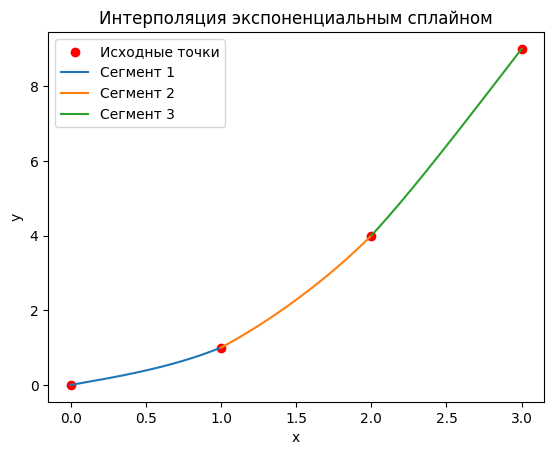

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class ExponentialSpline:
    class Segment:
        def __init__(self, p=0, x1=0, x2=0, f1=0, f2=0, t1=0, t2=0):
            self.p = p
            self.h = abs(x1 - x2)
            self.t1, self.t2, self.x1, self.x2, self.f1, self.f2 = t1, t2, x1, x2, f1, f2

        def __call__(self, x):
            return (self.t1 * np.sinh(self.p * (self.x2 - x)) + self.t2 * np.sinh(self.p * (x - self.x1))) / (
                    self.p ** 2 * np.sinh(self.p * self.h)) + \
                   (self.f1 - self.t1 / (self.p ** 2)) * (self.x2 - x) / self.h + \
                   (self.f2 - self.t2 / (self.p ** 2)) * (x - self.x1) / self.h

        def __str__(self):
            return (
                    f"({self.t1} * sinh({self.p} * ({self.x2} - x)) + {self.t2} * sinh({self.p} * (x - {self.x1}))) / "
                    f"{self.p ** 2 * np.sinh(self.p * self.h)} + "
                    f"{self.f1 - self.t1 / (self.p ** 2)} * ({self.x2} - x) / {self.h} + "
                    f"{self.f2 - self.t2 / (self.p ** 2)} * (x - {self.x1}) / {self.h}"
            )

    def __init__(self, x, y, p):
        self.x, self.y, self.p = np.array(x), np.array(y), np.array(p)
        self.h = np.abs(np.diff(self.x))
        self.d = (self.p * np.cosh(self.p * self.h) / np.sinh(self.p * self.h) - 1 / self.h) / (self.p ** 2)
        self.e = (1 / self.h - self.p / np.sinh(self.p * self.h)) / (self.p ** 2)
        self.b = np.zeros_like(self.x)
        self.t = np.zeros_like(self.x)
        self.segment = [self.Segment() for _ in range(len(self.x) - 1)]

        if len(self.x) != len(self.y) or len(self.x) - 1 != len(self.p):
            raise RuntimeError("Incompatible arrays")

        self.solve()

    def solve(self):
        n = len(self.h)
        for i in range(len(self.x) - 1):
            self.h[i] = np.abs(self.x[i + 1] - self.x[i])
            self.d[i] = (self.p[i] * np.cosh(self.p[i] * self.h[i]) / np.sinh(self.p[i] * self.h[i]) - 1 / self.h[i]) / (
                    self.p[i] ** 2)
            self.e[i] = (1 / self.h[i] - self.p[i] / np.sinh(self.p[i] * self.h[i])) / (self.p[i] ** 2)

        self.b[0] = 0
        self.b[-1] = 0
        for i in range(1, n):
            self.b[i] = (self.y[i + 1] - self.y[i]) / self.h[i] - (self.y[i] - self.y[i - 1]) / self.h[i - 1]

        matrix = TridiagonalMatrix(n + 1)
        matrix.b[0] = 1
        for i in range(1, n):
            matrix.a[i] = self.e[i - 1]
            matrix.b[i] = self.d[i - 1] + self.d[i]
            matrix.c[i] = self.e[i]
        matrix.b[n] = 1

        self.t = matrix.solve(self.b)

        for i in range(n):
            self.segment[i] = self.Segment(self.p[i], self.x[i], self.x[i + 1], self.y[i], self.y[i + 1], self.t[i],
                                           self.t[i + 1])

    def tense(self, relax):
        for k in range(1, len(self.t) - 1):
            if self.t[k] * self.b[k] < 0:
                lam = max(abs(self.b[k]), (self.d[k - 1] + self.d[k]) * abs(self.t[k])) / 2 / max(
                    abs(self.t[k - 1]), abs(self.t[k + 1]))
                for i in range(k - 1, k + 1):
                    new_p = 1 / np.sqrt(lam * self.h[i])
                    self.p[i] = self.p[i] + relax * (new_p - self.p[i])

        self.solve()

    def __len__(self):
        return len(self.segment)

    def __getitem__(self, index):
        return self.segment[index]

    def __call__(self, value):
        if value < self.x[0] or value > self.x[-1]:
            raise RuntimeError("Out of range")

        for i in range(len(self.x) - 1):
            if self.x[i] <= value <= self.x[i + 1]:
                return self.segment[i](value)

        return 0


class TridiagonalMatrix:
    def __init__(self, size):
        self.size = size
        self.a = np.zeros(size - 1)
        self.b = np.zeros(size)
        self.c = np.zeros(size - 1)

    def solve(self, d):
        n = len(d)
        c_prime = np.zeros(n - 1)
        d_prime = np.zeros(n)

        c_prime[0] = self.c[0] / self.b[0]
        d_prime[0] = d[0] / self.b[0]

        for i in range(1, n - 1):
            c_prime[i] = self.c[i] / (self.b[i] - self.a[i - 1] * c_prime[i - 1])
        for i in range(1, n):
            d_prime[i] = (d[i] - self.a[i - 1] * d_prime[i - 1]) / (self.b[i] - self.a[i - 1] * c_prime[i - 1])

        x = np.zeros_like(d)
        x[-1] = d_prime[-1]

        for i in range(n - 2, -1, -1):
            x[i] = d_prime[i] - c_prime[i] * x[i + 1]

        return x


def plot_exponential_spline(x_vals, y_vals, p_vals, num_points=1000):
    spline = ExponentialSpline(x_vals, y_vals, p_vals)

    plt.scatter(x_vals, y_vals, color='red', label='Исходные точки')
    for i in range(len(spline)):
        segment = spline[i]
        x_segment = np.linspace(segment.x1, segment.x2, num_points)
        y_segment = [segment(x) for x in x_segment]
        plt.plot(x_segment, y_segment, label=f'Сегмент {i + 1}')

    plt.legend()
    plt.title('Интерполяция экспоненциальным сплайном')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


x_values = [0, 1, 2, 3]
y_values = [0, 1, 4, 9]
p_values = [1, 2, 3]
plot_exponential_spline(x_values, y_values, p_values)


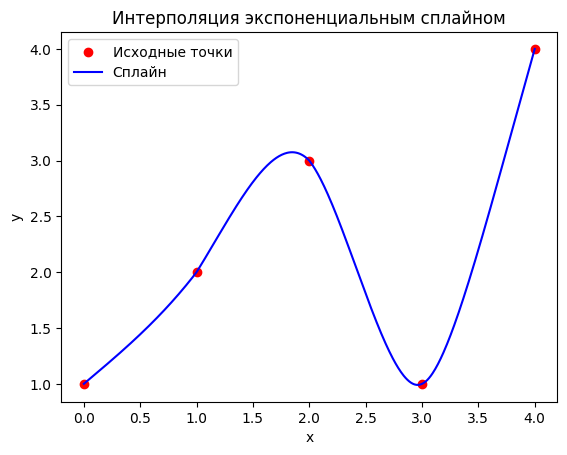

In [27]:
x_data = [0, 1, 2, 3, 4]
y_data = [1, 2, 3, 1, 4]
p_values = [1, 2, 3, 4]
spline = ExponentialSpline(x_data, y_data, p_values)

x_interpolated = np.linspace(min(x_data), max(x_data), 500)
y_interpolated = [spline(x) for x in x_interpolated]

plt.scatter(x_data, y_data, label='Исходные точки', color='red')
plt.plot(x_interpolated, y_interpolated, label='Сплайн', color='blue')
plt.title('Интерполяция экспоненциальным сплайном')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()